# 1.2A Pridobitev, podatkov za humani IDO1

V koraku Pridobitev, obdelava in analiza podatkov:
- pridobimo in združimo podatke z binding db in chembl podatkovnih baz
- pregledamo PAINS in BRENK strukture in jih po potrebi izločimo
- pregledamo fizikalno kemijske in ADME lastnosti aktivnih in neaktivnih molekul po izključitvah

# Uvoz knjižnic in splošnih funkcij

In [1]:
%run __A_knjiznice.py
from __A_knjiznice import *
from __C_konstante import *

%matplotlib inline

/Users/samonose/PycharmProjects/IDO_inhibitors_ML_predictions/dir1
/Users/samonose/PycharmProjects/IDO_inhibitors_ML_predictions/dir1


# Pridobitev podatkov

# Pridobitev podatkov z BindingDb

In [2]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

# Mapping of Uniprot IDs to organisms
uniprot_organism_map = {
    'P14902': 'Homo sapiens',
    # 'Q6ZQW0': 'Homo sapiens',
    # 'P48775': 'Homo sapiens',
    # 'P28776': 'Mus musculus',
    # 'Q8R0V5': 'Mus musculus',
    # 'P48776': 'Mus musculus' 
}

URL = [
    'https://bindingdb.org/axis2/services/BDBService/getLigandsByUniprot?uniprot=P14902;1000000',
    # 'https://bindingdb.org/axis2/services/BDBService/getLigandsByUniprot?uniprot=Q6ZQW0;1000000',
    # 'https://bindingdb.org/axis2/services/BDBService/getLigandsByUniprot?uniprot=P48775;1000000',
    # 'https://bindingdb.org/axis2/services/BDBService/getLigandsByUniprot?uniprot=P28776;1000000',
    # 'https://bindingdb.org/axis2/services/BDBService/getLigandsByUniprot?uniprot=Q8R0V5;1000000',
    # 'https://bindingdb.org/axis2/services/BDBService/getLigandsByUniprot?uniprot=P48776;1000000',
]

data = []

for url in URL:
    uniprot_id = url.split('?uniprot=')[1].split(';')[0]  # Extract Uniprot ID from the URL
    target_organism = uniprot_organism_map.get(uniprot_id, 'Unknown')  # Look up organism
    
    response = requests.get(url)
    if response.status_code == 200:
        print(f"Request {url} ok: {response.status_code}")
        xml_string = response.content
        root = ET.fromstring(xml_string)
        
        for aff in root.iter('{http://ws.bindingdb.org/xsd}affinities'):
            monomer_id = aff.find('{http://ws.bindingdb.org/xsd}monomerid').text
            smiles = aff.find('{http://ws.bindingdb.org/xsd}smiles').text
            affinity_type = aff.find('{http://ws.bindingdb.org/xsd}affinity_type').text
            affinity = aff.find('{http://ws.bindingdb.org/xsd}affinity').text
            
            # Add target_organism to the data list
            data.append([monomer_id, smiles, affinity_type, affinity, target_organism])
    else:
        print(f"Request to {url} failed with status code: {response.status_code}")

# Create DataFrame with target_organism column
df = pd.DataFrame(data, columns=['monomer_id', 'smiles', 'affinity_type', 'affinity', 'target_organism'])
binding_db_molecules = df

binding_db_molecules

Request https://bindingdb.org/axis2/services/BDBService/getLigandsByUniprot?uniprot=P14902;1000000 ok: 200


,monomer_id,smiles,affinity_type,affinity,target_organism
0,17448,c1[nH]nnc1-c1ccccc1,IC50,8900,Homo sapiens
1,17448,c1[nH]nnc1-c1ccccc1,Ki,22500,Homo sapiens
2,17452,Cc1ccccc1-c1c[nH]nn1,IC50,39000,Homo sapiens
3,17453,COc1ccccc1-c1c[nH]nn1,IC50,>100000,Homo sapiens
4,17459,Clc1ccc(cc1)-c1c[nH]nn1,IC50,530000,Homo sapiens
...,...,...,...,...,...
4678,50614706,C[C@H]1C\C=C/[C@@H](c2ccccc2)c2cc(cc(NC(=O)Nc3...,IC50,12,Homo sapiens
4679,50614707,C[C@H]1CCC[C@@H](c2ccccc2)c2cc(cc(NC(=O)Nc3ccc...,IC50,25,Homo sapiens
4680,50614708,Cc1ccc(NC(=O)Nc2cc(cc3C(C=CCOc23)c2ccccc2)-c2c...,IC50,11,Homo sapiens
4681,50614709,Cc1ccc(NC(=O)Nc2cc(cc3C(CCCOc23)c2ccccc2)-c2cc...,IC50,1.5,Homo sapiens


In [3]:
filename = 'binding_db_molecules.csv'
dir_path = os.path.join(PATH, filename)
binding_db_molecules.to_csv(dir_path,index=False)

In [4]:
# odstranim NA vrednosti

binding_db_molecules.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {binding_db_molecules.shape}")

DataFrame shape: (4683, 5)


In [5]:
# podatkovni okvir filtriram tako da spremljamo le IC50 vrednosti

binding_db_molecules = binding_db_molecules[binding_db_molecules['affinity_type'] == 'IC50']
binding_db_molecules.shape

(4186, 5)

In [6]:
# afiniteto preimenujem v IC50, odstranim tudi ne-enacaje

warnings.filterwarnings("ignore")

binding_db_molecules['affinity'] = binding_db_molecules['affinity'].str.replace('[><]', '', regex=True)

binding_db_molecules = binding_db_molecules.astype({"affinity": "float64"})

binding_db_molecules.drop(columns=['affinity_type'],  inplace=True)

binding_db_molecules.rename(
    columns={"affinity": "IC50"}, inplace=True
)
#binding_db_molecules.head()

In [7]:
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [8]:
# Apply conversion to each row of the compounds DataFrame
binding_db_molecules["pIC50"] = binding_db_molecules.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)
binding_db_molecules

,monomer_id,smiles,IC50,target_organism,pIC50
0,17448,c1[nH]nnc1-c1ccccc1,8900.0,Homo sapiens,5.050610
2,17452,Cc1ccccc1-c1c[nH]nn1,39000.0,Homo sapiens,4.408935
3,17453,COc1ccccc1-c1c[nH]nn1,100000.0,Homo sapiens,4.000000
4,17459,Clc1ccc(cc1)-c1c[nH]nn1,530000.0,Homo sapiens,3.275724
5,17462,Cc1cccc(c1)-c1c[nH]nn1,7000.0,Homo sapiens,5.154902
...,...,...,...,...,...
4678,50614706,C[C@H]1C\C=C/[C@@H](c2ccccc2)c2cc(cc(NC(=O)Nc3...,12.0,Homo sapiens,7.920819
4679,50614707,C[C@H]1CCC[C@@H](c2ccccc2)c2cc(cc(NC(=O)Nc3ccc...,25.0,Homo sapiens,7.602060
4680,50614708,Cc1ccc(NC(=O)Nc2cc(cc3C(C=CCOc23)c2ccccc2)-c2c...,11.0,Homo sapiens,7.958607
4681,50614709,Cc1ccc(NC(=O)Nc2cc(cc3C(CCCOc23)c2ccccc2)-c2cc...,1.5,Homo sapiens,8.823909


In [9]:
# unikatnih smilesov je manj kot vseh vrstic, torej imamo prisotne duplikate
n_unique_smiles_w_ic_50 = binding_db_molecules['smiles'].nunique()
n_unique_smiles_w_ic_50

4186

Pristop za duplikate je tak da kadar imam rezulata na cloveku in misi vzamem le rezultat cloveka. Ko imam duplikate znotraj tarcnega organizma pa vzamem nizji IC50

In [10]:
binding_db_mol = binding_db_molecules.sort_values(by=['monomer_id','target_organism', 'IC50'], ascending=[True, True, True])
binding_db_mol_2 = binding_db_mol.drop_duplicates(subset='monomer_id', keep='first').reset_index(drop=True)
binding_db_mol_2

,monomer_id,smiles,IC50,target_organism,pIC50
0,168435,CC(C)CN(C1CCCCC1)c1ccc(cc1NC(=O)Nc1cc(C)no1)[C...,0.5,Homo sapiens,9.301030
1,17448,c1[nH]nnc1-c1ccccc1,8900.0,Homo sapiens,5.050610
2,17452,Cc1ccccc1-c1c[nH]nn1,39000.0,Homo sapiens,4.408935
3,17453,COc1ccccc1-c1c[nH]nn1,100000.0,Homo sapiens,4.000000
4,17459,Clc1ccc(cc1)-c1c[nH]nn1,530000.0,Homo sapiens,3.275724
...,...,...,...,...,...
4181,83922,Cc1coc-2c1C(=O)C(=O)c1c3CCCC(C)(C)c3ccc-21,10000.0,Homo sapiens,5.000000
4182,87319,N1c2ccccc2Sc2cnccc12,421600.0,Homo sapiens,3.375099
4183,91466,COCCn1c2ccccc2nc2c1nc(=O)n(-c1ccccc1)c2=O,23770.0,Homo sapiens,4.623971
4184,92508,FC(F)(F)c1cccc(NC(=O)C(C#N)C(=S)Nc2ccccc2Cl)c1,6300.0,Homo sapiens,5.200659


In [11]:
#binding_db_molecules.hist(column="pIC50")

In [12]:
# binding_db_molecules = binding_db_molecules.to_csv('binding_db_molecules.csv')
# binding_db_molecules = pd.read_csv('binding_db_molecules.csv')
# #binding_db_molecules

In [13]:
binding_db_molecules = binding_db_mol_2

def smiles_to_canonical(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        canonical_smiles = Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)
        return canonical_smiles
    else:
        return None  # Handle invalid SMILES

# Apply the function to the 'smiles' column and store the results in a new 'canonical_smiles' column
binding_db_molecules['smiles'] = binding_db_molecules['smiles'].apply(smiles_to_canonical)
binding_db_molecules.dropna(subset=['smiles'], inplace=True)
binding_db_molecules.head()

[21:38:50] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 12 13 14
[21:38:50] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 14 15 16
[21:38:50] SMILES Parse Error: syntax error while parsing: [K;v0+].[#8-]-[#6](=O)-c1cccc(-[#7]-[#6](=O)-c2c-3c(-[#6](=O)-c4cccnc4-[#6]-3=O)n3ccccc23)c1
[21:38:50] SMILES Parse Error: Failed parsing SMILES '[K;v0+].[#8-]-[#6](=O)-c1cccc(-[#7]-[#6](=O)-c2c-3c(-[#6](=O)-c4cccnc4-[#6]-3=O)n3ccccc23)c1' for input: '[K;v0+].[#8-]-[#6](=O)-c1cccc(-[#7]-[#6](=O)-c2c-3c(-[#6](=O)-c4cccnc4-[#6]-3=O)n3ccccc23)c1'
[21:38:50] SMILES Parse Error: syntax error while parsing: [K;v0+].[#8-]-[#6](=O)-c1cccc(-[#7]-[#6](=O)-c2c-3c(-[#6](=O)-c4ncccc4-[#6]-3=O)n3ccccc23)c1
[21:38:50] SMILES Parse Error: Failed parsing SMILES '[K;v0+].[#8-]-[#6](=O)-c1cccc(-[#7]-[#6](=O)-c2c-3c(-[#6](=O)-c4ncccc4-[#6]-3=O)n3ccccc23)c1' for input: '[K;v0+].[#8-]-[#6](=O)-c1cccc(-[#7]-[#6](=O)-c2c-3c(-[#6](=O)-c4ncccc4-[#6]-3=O)n3ccccc23)c1'
[21:38:50] SMILES Parse Error: syntax error while

,monomer_id,smiles,IC50,target_organism,pIC50
0,168435,Cc1cc(NC(=O)Nc2cc([C@H]3C[C@H]3C(=O)O)ccc2N(CC...,0.5,Homo sapiens,9.301030
1,17448,c1ccc(-c2c[nH]nn2)cc1,8900.0,Homo sapiens,5.050610
2,17452,Cc1ccccc1-c1c[nH]nn1,39000.0,Homo sapiens,4.408935
3,17453,COc1ccccc1-c1c[nH]nn1,100000.0,Homo sapiens,4.000000
4,17459,Clc1ccc(-c2c[nH]nn2)cc1,530000.0,Homo sapiens,3.275724


,monomer_id,smiles,IC50,target_organism,pIC50,ROMol
0,50442991,O=C1c2cc([N+](=O)[O-])ccc2-n2c1nc1ccccc1c2=O,0.018,Homo sapiens,10.744727,
1,50604021,Cc1cc(C2CC2)ncc1-c1ccc(C2(C(=O)Nc3ccc(F)cc3)CO...,0.080,Homo sapiens,10.096910,
2,50538503,O=C(Nc1ccc(C2(C(=O)Nc3ccc(F)cc3)COC2)cc1)c1ccc...,0.090,Homo sapiens,10.045757,
3,50567132,O=C(Nc1ccc(F)cc1)C1(C2CCC3C(CCCN3c3ccnc(C(F)(F...,0.100,Homo sapiens,10.000000,
4,309529,O=C1CC(c2c[nH]c3ccc(F)cc23)C(=O)N1,0.120,Homo sapiens,9.920819,
...,...,...,...,...,...,...
4122,32203,Oc1cccc2cccnc12,750000.000,Homo sapiens,3.124939,
4123,50051819,Clc1ccc(CCn2ccnc2)c(Cl)c1,820000.000,Homo sapiens,3.086186,
4124,24676,O=Cc1cccc(-c2c[nH]cn2)c1,825000.000,Homo sapiens,3.083546,
4125,50051840,OC(Cn1ccnc1)c1ccc(Cl)c(Cl)c1,830000.000,Homo sapiens,3.080922,

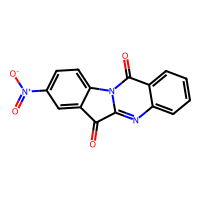
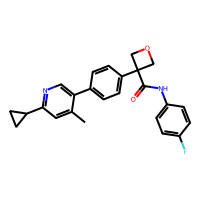
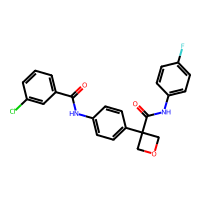
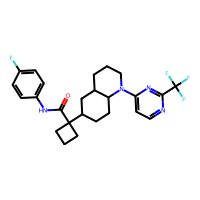
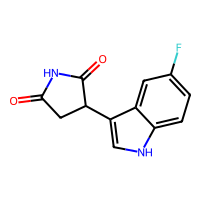
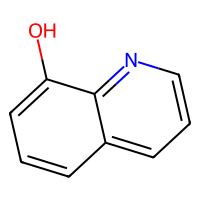
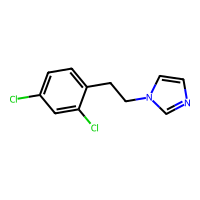
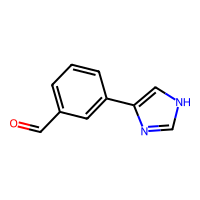
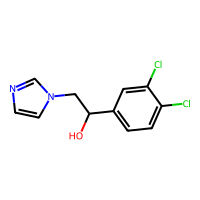
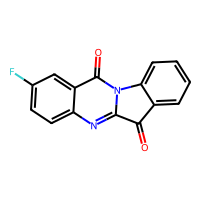

In [14]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(binding_db_molecules, smilesCol="smiles")
# Sort molecules by pIC50
binding_db_molecules.sort_values(by="pIC50", ascending=False, inplace=True)

# Reset index
binding_db_molecules.reset_index(drop=True, inplace=True)
binding_db_molecules

In [15]:
filename = 'binding_db_molecules_filtered.csv'
dir_path = os.path.join(PATH, filename)
binding_db_molecules.to_csv(dir_path,index=False)

# Pridobitev podatkov z chEMBL

In [16]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

type(targets_api)


uniprot_id = ["P14902"] # "Q6ZQW0","P48775", "P28776", "Q8R0V5", "P48776"


# Get target information from ChEMBL but restrict it to specified values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

targets = pd.DataFrame.from_records(targets)
targets.drop_duplicates(inplace=True)
targets

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,"Indoleamine 2,3-dioxygenase",CHEMBL4685,SINGLE PROTEIN
2,Homo sapiens,"Cereblon/Indoleamine 2,3-dioxygenase 1",CHEMBL4742272,PROTEIN-PROTEIN INTERACTION
3,Homo sapiens,IDO1/VHL,CHEMBL5169061,PROTEIN-PROTEIN INTERACTION


In [17]:
targets_df = targets[targets['target_type'] == 'SINGLE PROTEIN']
targets_df

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,"Indoleamine 2,3-dioxygenase",CHEMBL4685,SINGLE PROTEIN


In [18]:
target = targets_df
chembl_id = target['target_chembl_id']
chembl_id_list = chembl_id.to_list()
chembl_id_list

['CHEMBL4685']

In [19]:
bioactivities = bioactivities_api.filter(
    target_chembl_id__in = chembl_id_list, type="IC50", relation="=", assay_type="B"
).only(
        "activity_id",
        "assay_chembl_id",
        "assay_description",
        "assay_type",
        "molecule_chembl_id",
        "type",
        "standard_units",
        "relation",
        "standard_value",
        "target_chembl_id",
        "target_organism",
    )

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 3238, <class 'chembl_webresource_client.query_set.QuerySet'>


In [20]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
#bioactivities[0]

Length and type of first element: 13, <class 'dict'>


In [21]:
bioactivities_df = pd.DataFrame.from_dict(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
#bioactivities_df.head()

DataFrame shape: (3238, 13)


In [22]:
filename = 'chembl_molecules.csv'
dir_path = os.path.join(PATH, filename)
bioactivities_df.to_csv(dir_path,index=False)

In [23]:
bioactivities_df["units"].unique()

array(['uM', 'nM', 'mM', "10'-2M", "10'-5M", 'ug ml-1'], dtype=object)

In [24]:
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,2120165,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL318782,=,nM,280.0,CHEMBL4685,Homo sapiens,IC50
1,2120166,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL271826,=,nM,1500.0,CHEMBL4685,Homo sapiens,IC50
2,2120167,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL272225,=,nM,512.0,CHEMBL4685,Homo sapiens,IC50
3,2120168,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL441441,=,nM,4340.0,CHEMBL4685,Homo sapiens,IC50
4,2120169,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL258816,=,nM,2120.0,CHEMBL4685,Homo sapiens,IC50


In [25]:
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
# bioactivities_df.dtypes

In [26]:
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (3238, 11)


In [27]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (3238, 11)


In [28]:
bioactivities_df

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,2120165,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL318782,=,nM,280.0,CHEMBL4685,Homo sapiens,IC50
1,2120166,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL271826,=,nM,1500.0,CHEMBL4685,Homo sapiens,IC50
2,2120167,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL272225,=,nM,512.0,CHEMBL4685,Homo sapiens,IC50
3,2120168,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL441441,=,nM,4340.0,CHEMBL4685,Homo sapiens,IC50
4,2120169,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL258816,=,nM,2120.0,CHEMBL4685,Homo sapiens,IC50
...,...,...,...,...,...,...,...,...,...,...,...
3233,25093858,CHEMBL5259436,Inhibition of IDO1 (unknown origin) expressed ...,B,CHEMBL5273615,=,nM,1.5,CHEMBL4685,Homo sapiens,IC50
3234,25093859,CHEMBL5259436,Inhibition of IDO1 (unknown origin) expressed ...,B,CHEMBL5273615,=,nM,4.6,CHEMBL4685,Homo sapiens,IC50
3235,25093860,CHEMBL5259436,Inhibition of IDO1 (unknown origin) expressed ...,B,CHEMBL5267407,=,nM,3.6,CHEMBL4685,Homo sapiens,IC50
3236,25093861,CHEMBL5259436,Inhibition of IDO1 (unknown origin) expressed ...,B,CHEMBL5267407,=,nM,15.0,CHEMBL4685,Homo sapiens,IC50


In [29]:
bioactivities_df["standard_units"].unique()

array(['nM', 'ug.mL-1'], dtype=object)

In [30]:
bioactivities_df["relation"].unique()

array(['='], dtype=object)

In [31]:
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")

Units after filtering: ['nM']


In [32]:
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")

Units after filtering: ['nM']


In [33]:
bioactivities_df.reset_index(drop=True, inplace=True)
#bioactivities_df.head()

In [34]:
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,2120165,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL318782,=,nM,280.0,CHEMBL4685,Homo sapiens,IC50
1,2120166,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL271826,=,nM,1500.0,CHEMBL4685,Homo sapiens,IC50
2,2120167,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL272225,=,nM,512.0,CHEMBL4685,Homo sapiens,IC50
3,2120168,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL441441,=,nM,4340.0,CHEMBL4685,Homo sapiens,IC50
4,2120169,CHEMBL935410,Inhibition of purified human recombinant IDO,B,CHEMBL258816,=,nM,2120.0,CHEMBL4685,Homo sapiens,IC50


In [35]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (3237, 11)


In [36]:
# Duplikate naslovim na tak nacin da prioretiziram rezultate IC50 pridobljene na humanem encimu, in nato gledam najnizji rezultat

bioactivities_df.sort_values(by=['molecule_chembl_id', 'target_organism', 'IC50'], ascending=[True, True, True], inplace=True)

bioactivities_df.drop_duplicates(subset=['molecule_chembl_id'], keep='first', inplace=True)

print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (2186, 11)


In [37]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

In [38]:
compounds = list(tqdm(compounds_provider))

  0%|          | 0/2186 [00:00<?, ?it/s]

In [39]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (2186, 2)


In [40]:
compounds_df.head()

,molecule_chembl_id,molecule_structures
0,CHEMBL91,{'canonical_smiles': 'Clc1ccc(COC(Cn2ccnc2)c2c...
1,CHEMBL275224,{'canonical_smiles': 'c1ccc2c(c1)[nH]c1cnccc12...
2,CHEMBL14145,"{'canonical_smiles': 'c1ccc(-c2c[nH]cn2)cc1', ..."
3,CHEMBL274452,{'canonical_smiles': 'c1ccc2c(c1)[nH]c1c(-c3c[...
4,CHEMBL15192,{'canonical_smiles': 'CC1(C)CCC2=C(O1)c1ccccc1...


In [41]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (2186, 2)


In [42]:
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (2186, 2)


In [43]:
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [44]:
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (2186, 2)


In [45]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (2186, 2)


In [46]:
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
bioactivities_df.columns

Bioactivities filtered: 2186


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'units', 'IC50', 'target_chembl_id',
       'target_organism', 'type'],
      dtype='object')

In [47]:
print(f"Compounds filtered: {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered: 2186


Index(['molecule_chembl_id', 'smiles'], dtype='object')

In [48]:
# Merge DataFrames
chembl_molecules = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units", 'target_organism']],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
chembl_molecules.reset_index(drop=True, inplace=True)

print(f"Dataset with {chembl_molecules.shape[0]} entries.")

Dataset with 2186 entries.


In [49]:
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [50]:
# Apply conversion to each row of the compounds DataFrame
chembl_molecules["pIC50"] = chembl_molecules.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)
#output_df.head()

,molecule_chembl_id,IC50,units,target_organism,smiles,pIC50,ROMol
0,CHEMBL432537,0.018,nM,Homo sapiens,O=C1c2cc([N+](=O)[O-])ccc2-n2c1nc1ccccc1c2=O,10.744727,
1,CHEMBL5207194,0.080,nM,Homo sapiens,Cc1cc(C2CC2)ncc1-c1ccc(C2(C(=O)Nc3ccc(F)cc3)CO...,10.096910,
2,CHEMBL4645108,0.090,nM,Homo sapiens,O=C(Nc1ccc(C2(C(=O)Nc3ccc(F)cc3)COC2)cc1)c1ccc...,10.045757,
3,CHEMBL4863767,0.100,nM,Homo sapiens,O=C(Nc1ccc(F)cc1)C1(C2CCC3C(CCCN3c3ccnc(C(F)(F...,10.000000,
4,CHEMBL4086143,0.120,nM,Homo sapiens,O=C1CC(c2c[nH]c3ccc(F)cc23)C(=O)N1,9.920819,
...,...,...,...,...,...,...,...
2181,CHEMBL2147988,2300000.000,nM,Homo sapiens,FC(F)(F)c1ccc(-c2c[nH]nn2)cc1,2.638272,
2182,CHEMBL84963,2570000.000,nM,Homo sapiens,c1ccc2[nH]nnc2c1,2.590067,
2183,CHEMBL2148080,3000000.000,nM,Homo sapiens,Cc1cccc(NC(=O)C(F)(F)F)c1-c1c[nH]nn1,2.522879,
2184,CHEMBL2148081,3200000.000,nM,Homo sapiens,Cc1ccc(N)cc1-c1c[nH]nn1,2.494850,

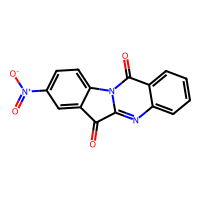
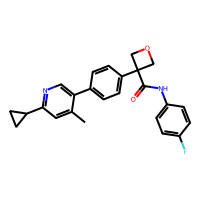
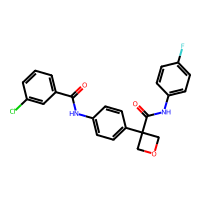
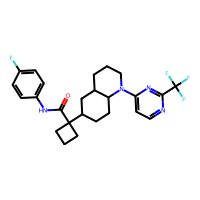
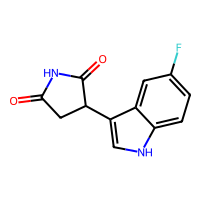
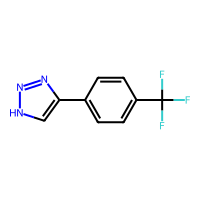
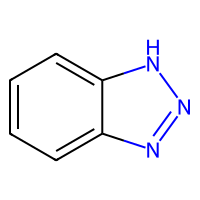
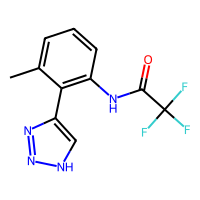
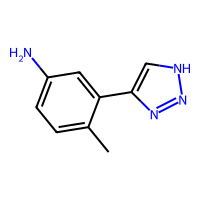
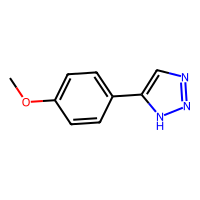

In [51]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(chembl_molecules, smilesCol="smiles")
# Sort molecules by pIC50
chembl_molecules.sort_values(by="pIC50", ascending=False, inplace=True)

# Reset index
chembl_molecules.reset_index(drop=True, inplace=True)
chembl_molecules

In [52]:
filename = 'chembl_molecules_filtered.csv'
dir_path = os.path.join(PATH, filename)
chembl_molecules.to_csv(dir_path,index=False)

# Združitev podatkov

In [53]:
selected_columns = ['smiles', 'IC50', 'pIC50','ROMol', 'target_organism']
chembl_molecules_join = chembl_molecules[selected_columns]

binding_db_molecules_join = binding_db_molecules[selected_columns]

joined_df = pd.concat([chembl_molecules_join,binding_db_molecules_join])
joined_df.reset_index(drop=True, inplace=True)
joined_df

,smiles,IC50,pIC50,ROMol,target_organism
0,O=C1c2cc([N+](=O)[O-])ccc2-n2c1nc1ccccc1c2=O,0.018,10.744727,<rdkit.Chem.rdchem.Mol object at 0x16f43e420>,Homo sapiens
1,Cc1cc(C2CC2)ncc1-c1ccc(C2(C(=O)Nc3ccc(F)cc3)CO...,0.080,10.096910,<rdkit.Chem.rdchem.Mol object at 0x16f45dc40>,Homo sapiens
2,O=C(Nc1ccc(C2(C(=O)Nc3ccc(F)cc3)COC2)cc1)c1ccc...,0.090,10.045757,<rdkit.Chem.rdchem.Mol object at 0x16f44af10>,Homo sapiens
3,O=C(Nc1ccc(F)cc1)C1(C2CCC3C(CCCN3c3ccnc(C(F)(F...,0.100,10.000000,<rdkit.Chem.rdchem.Mol object at 0x16f457e60>,Homo sapiens
4,O=C1CC(c2c[nH]c3ccc(F)cc23)C(=O)N1,0.120,9.920819,<rdkit.Chem.rdchem.Mol object at 0x16f42e260>,Homo sapiens
...,...,...,...,...,...
6308,Oc1cccc2cccnc12,750000.000,3.124939,<rdkit.Chem.rdchem.Mol object at 0x34fb3af10>,Homo sapiens
6309,Clc1ccc(CCn2ccnc2)c(Cl)c1,820000.000,3.086186,<rdkit.Chem.rdchem.Mol object at 0x34fb5c9e0>,Homo sapiens
6310,O=Cc1cccc(-c2c[nH]cn2)c1,825000.000,3.083546,<rdkit.Chem.rdchem.Mol object at 0x34fb38430>,Homo sapiens
6311,OC(Cn1ccnc1)c1ccc(Cl)c(Cl)c1,830000.000,3.080922,<rdkit.Chem.rdchem.Mol object at 0x34fb5cc10>,Homo sapiens


In [54]:
joined_df.sort_values(by=['smiles','target_organism', 'IC50'], ascending=[True, True, True], inplace=True)

# Now, drop duplicates based on 'monomer_id' while keeping the first occurrence
joined_df = joined_df.drop_duplicates(subset='smiles', keep='first').reset_index(drop=True)

print(f"DataFrame shape: {joined_df.shape}")


DataFrame shape: (4291, 5)


In [55]:
unique_count = joined_df['smiles'].nunique()
print(unique_count)

4291


array([[<Axes: title={'center': 'pIC50'}>]], dtype=object)

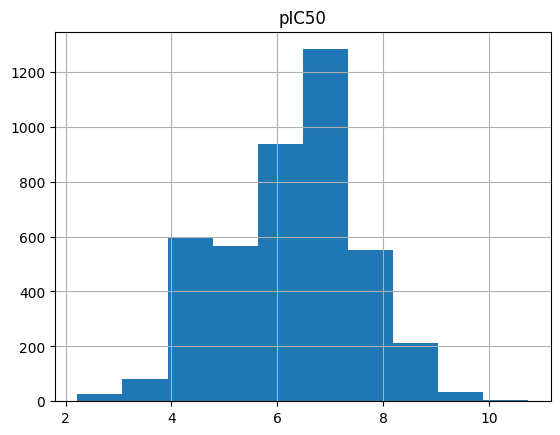

In [56]:
joined_df.hist(column="pIC50")

,smiles,IC50,pIC50,ROMol,target_organism
0,O=C1c2cc([N+](=O)[O-])ccc2-n2c1nc1ccccc1c2=O,0.018,10.744727,,Homo sapiens
1,Cc1cc(C2CC2)ncc1-c1ccc(C2(C(=O)Nc3ccc(F)cc3)CO...,0.080,10.096910,,Homo sapiens
2,O=C(Nc1ccc(C2(C(=O)Nc3ccc(F)cc3)COC2)cc1)c1ccc...,0.090,10.045757,,Homo sapiens
3,O=C(Nc1ccc(F)cc1)C1(C2CCC3C(CCCN3c3ccnc(C(F)(F...,0.100,10.000000,,Homo sapiens
4,O=C1CC(c2c[nH]c3ccc(F)cc23)C(=O)N1,0.120,9.920819,,Homo sapiens
...,...,...,...,...,...
4286,FC(F)(F)c1ccc(-c2c[nH]nn2)cc1,2300000.000,2.638272,,Homo sapiens
4287,c1ccc2[nH]nnc2c1,2570000.000,2.590067,,Homo sapiens
4288,Cc1cccc(NC(=O)C(F)(F)F)c1-c1c[nH]nn1,3000000.000,2.522879,,Homo sapiens
4289,Cc1ccc(N)cc1-c1c[nH]nn1,3200000.000,2.494850,,Homo sapiens

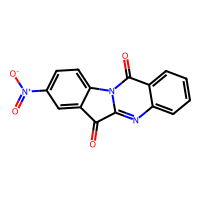
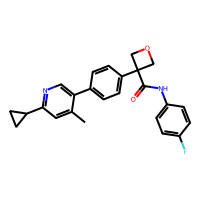
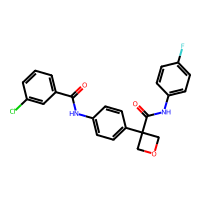
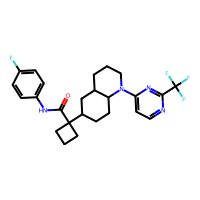
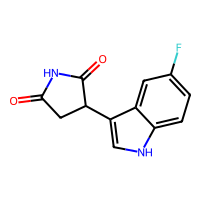
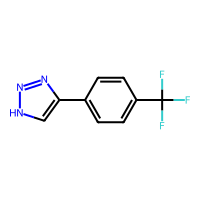
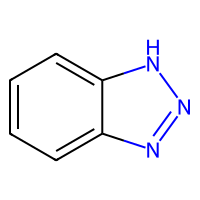
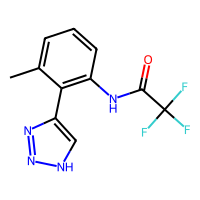
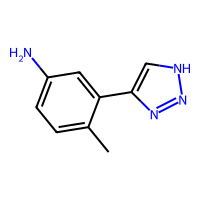
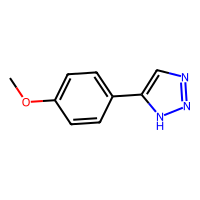

In [57]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(joined_df, smilesCol="smiles")
# Sort molecules by pIC50
joined_df.sort_values(by="pIC50", ascending=False, inplace=True)

# Reset index
joined_df.reset_index(drop=True, inplace=True)
joined_df

In [58]:
joined_df.to_csv(f'{path_files}/joined_df.csv', index=False)